In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import random
import pickle as pkl
import gzip

import games
import synthetic_data

In [2]:
class Evaluate:

    def __init__(self, ):
        pass

    def get_feedback(self, game, action, outcome ):
        return game.FeedbackMatrix[ action ][ outcome ]
        
    def deploy(self, game, horizon, alg, context_generator):

        history = [] 
        cumRegret =  []
        t = 0
        global_loss = []
        global_losses = []
        
        for t in range(horizon):
            
            context, distribution = context_generator.get_context()
            context = context.reshape( (1, -1) )
            outcome = np.argmax(distribution) 
            # distribution = np.array([1-outcome, outcome])
            #print('distribution', distribution, 'outcome', outcome, )

            #print('context shape',context.shape)
            action, data = alg.get_action(t, context)

            data['context'] = context 
            history.append( data )
            
            feedback =  self.get_feedback( game, action, outcome )

            loss, losses = alg.update(action, feedback, outcome, t, context )            

            global_loss.append(loss)
            global_losses.append(losses)

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            cumRegret.append( val )
            t+=1

            print('t', t, 'action', action, 'outcome', outcome, 'regret',val)
            print()
            
        return history, cumRegret, global_loss, global_losses

In [3]:
import cbpside
import rand_cbpside
import randneuralcbp
import cesa_bianchi
import random_algo
import random_algo2
import old_files.ineural as ineural
import ineural_multi
import margin_based
# import neuralcbp_EE_kclasses
import neuralcbp_EE_kclasses_v5
import neuronal

seed = 3
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

m = 100
horizon = 10000

##### train and test data:

context_generator = synthetic_data.MNISTcontexts()
context_generator.initiate_loader()

game = games.game_case2( {} )

# nclasses = 10
# alg = random_algo.Egreedy(game, nclasses, m, 'cuda:0')
# alg.reset(context_generator.d)

# lbd_neural = 0
# lbd_reg = 1
# sigma = 1/8
# K = 100
# epsilon = 10e-7
# alg = randneuralcbp.CBPside( game, 1.01, lbd_neural, lbd_reg, sigma, K, epsilon, m, H,  'cuda:0')
# alg.reset(context_generator.d)

# budget = 9999
# nclasses = 10
# alg = ineural_multi.INeurALmulti(budget, nclasses, 'cuda:0')
# alg.reset(context_generator.d)

# lbd_neural = 0
# lbd_reg = 1
# nclasses = 10
# alg = neuralcbp_EE_kclasses.CBPside( game, 1.01, lbd_neural, lbd_reg, m, H, nclasses,  'cuda:0')
# alg.reset(context_generator.d)


# nclasses = 2
# alg = neuralcbp_EE_kclasses_v5.CBPside( game, 1.01, m,  nclasses,  'cuda:0')
# alg.reset(context_generator.d)


budget = 9999
nclasses = 10
alg = neuronal.NeuronAL(budget, nclasses, 'cuda:0')
alg.reset(context_generator.d)

evaluator = Evaluate()

In [4]:
history, cumRegret, global_loss, global_losses = evaluator.deploy(game, horizon, alg, context_generator)

X shape (1, 784)
dc shape torch.Size([1560])
pred 9
t 1 action 0 outcome 5 regret 1

X shape (1, 784)
dc shape torch.Size([1560])
pred 6
t 2 action 0 outcome 9 regret 1

X shape (1, 784)
dc shape torch.Size([1560])
pred 10
t 3 action 10 outcome 9 regret 0

X shape (1, 784)
dc shape torch.Size([1560])
pred 6
t 4 action 0 outcome 0 regret 1

X shape (1, 784)
dc shape torch.Size([1560])
pred 9
t 5 action 0 outcome 5 regret 1

X shape (1, 784)
dc shape torch.Size([1560])
pred 6
t 6 action 0 outcome 9 regret 1

X shape (1, 784)
dc shape torch.Size([1560])
pred 10
t 7 action 10 outcome 6 regret 1

X shape (1, 784)
dc shape torch.Size([1560])
pred 1
t 8 action 0 outcome 3 regret 1

X shape (1, 784)
dc shape torch.Size([1560])
pred 1
t 9 action 0 outcome 8 regret 1

X shape (1, 784)
dc shape torch.Size([1560])
pred 6
t 10 action 6 outcome 0 regret 1

X shape (1, 784)
dc shape torch.Size([1560])
pred 10
t 11 action 0 outcome 4 regret 1

X shape (1, 784)
dc shape torch.Size([1560])
pred 6
t 12 a

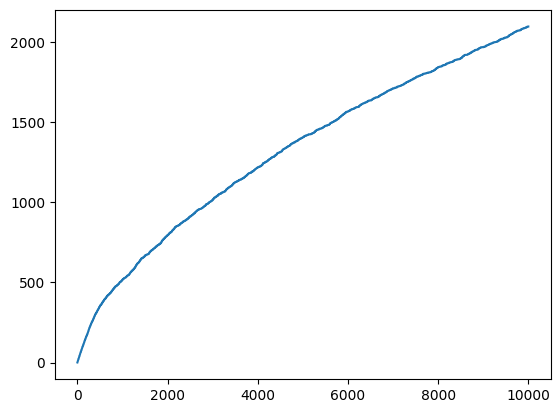

In [6]:
plt.plot( np.cumsum(cumRegret) )
# plt.ylim( (0,10000) )

(0.0, 10000.0)

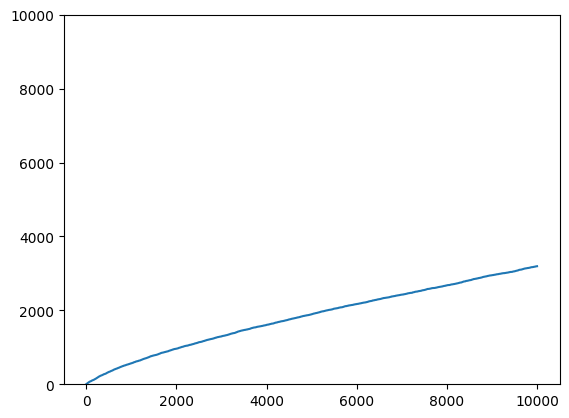

In [5]:
plt.plot( np.cumsum(cumRegret) )
plt.ylim( (0,10000) )

In [6]:
class Network_exploitation(nn.Module):

    def __init__(self, game, dim, hidden_size=100):
        super(Network_exploitation, self).__init__()
        self.game = game
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()

        self.heads = nn.ModuleDict()
        for k in range(self.game.N):
            sigma_i = len( np.unique(self.game.FeedbackMatrix[k]) )
            print('sigma_i', sigma_i)
            self.heads[str(k)] = nn.Linear(hidden_size, sigma_i)

    def forward(self, x):
        latent = self.fc1(x)
        x = self.activate(latent)
        outputs = {}
        for k in range(self.game.N):
            outputs[str(k)] = self.heads[str(k)](x)
        return outputs, latent
    


class Network_exploration(nn.Module):

    def __init__(self, game, dim, hidden_size=100):
        super(Network_exploration, self).__init__()
        self.game = game
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()

        self.heads = nn.ModuleDict()
        for k in range(game.N):
            sigma_i = len( np.unique(self.game.SignalMatrices[k]) )
            self.heads[str(k)] = nn.Linear(hidden_size, sigma_i)

    def forward(self, x):
        latent = self.fc1(x)
        x = self.activate(latent)
        outputs = {}
        for k in range(self.game.N):
            outputs[str(k)] = self.heads[str(k)](x)
        return outputs

def EE_forward(game, net1, net2, x):
    x.requires_grad = True
    f1, latent = net1(x)
    net1.zero_grad()

    gradients = []
    for k in range(game.N):
        # Compute backward pass for each head
        f1[str(k)].sum().backward(retain_graph=True)

        grad_last_layer = net1.heads[str(k)].weight.grad

        # Flatten and detach the gradient
        grad_flat = grad_last_layer.flatten().detach()

        # Store the gradient
        gradients.append(grad_flat)

        # Zero out gradients for the next head
        net1.zero_grad()

    gradients.append( latent[0].detach() )
    # print(gradients)

    dc = torch.cat(gradients)
    print('dc', dc.shape)

    dc_normalized = dc / torch.linalg.norm(dc)
    f2 = net2(dc_normalized)

    return f1, f2, dc_normalized.to(torch.float16)

game = games.game_case2( {} )

m = 100
A = 20
d =  700

input_dim = m + m * A
print('input dim', input_dim)

net1 = Network_exploitation(game, d,m).to('cuda:0')

net2 = Network_exploration(game, input_dim, m).to('cuda:0')

x = torch.ones((1,700)).to('cuda:0')

f1, f2, dc_normalized  = EE_forward(game,net1, net2, x)




# def convert_pred_format(pred):
#     for k in range(game.N):
#         pred[str(k)] = pred[str(k)].detach().cpu().numpy()
#     return pred

# def convert_conf_format(pred):
#     for k in range(game.N):
#         pred[str(k)] = pred[str(k)].detach().cpu().numpy()
#         pred[str(k)] = np.array([max(pred[str(k)])])
#     return pred

# # convert_pred_format(f1)
# convert_conf_format(f2)

input dim 2100
sigma_i 10
sigma_i 1
sigma_i 1
sigma_i 1
sigma_i 1
sigma_i 1
sigma_i 1
sigma_i 1
sigma_i 1
sigma_i 1
sigma_i 1
dc torch.Size([2100])


In [9]:
net1

Network_exploitation(
  (fc1): Linear(in_features=700, out_features=100, bias=True)
  (activate): ReLU()
  (heads): ModuleDict(
    (0): Linear(in_features=100, out_features=2, bias=True)
    (1): Linear(in_features=100, out_features=1, bias=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): Linear(in_features=100, out_features=1, bias=True)
    (4): Linear(in_features=100, out_features=1, bias=True)
    (5): Linear(in_features=100, out_features=1, bias=True)
    (6): Linear(in_features=100, out_features=1, bias=True)
    (7): Linear(in_features=100, out_features=1, bias=True)
    (8): Linear(in_features=100, out_features=1, bias=True)
    (9): Linear(in_features=100, out_features=1, bias=True)
    (10): Linear(in_features=100, out_features=1, bias=True)
  )
)

(0.0, 10000.0)

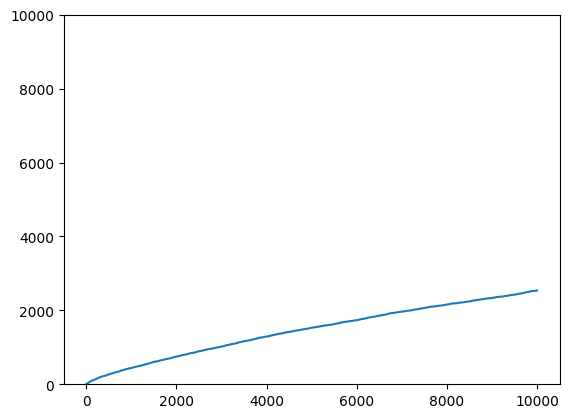

In [5]:
plt.plot( np.cumsum(cumRegret) )
plt.ylim( (0,10000) )

(0.0, 10000.0)

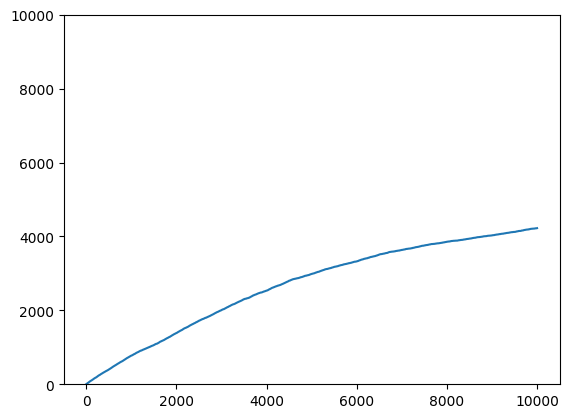

In [5]:
plt.plot( np.cumsum(cumRegret) )
plt.ylim( (0,10000) )

Text(0, 0.5, 'Loss')

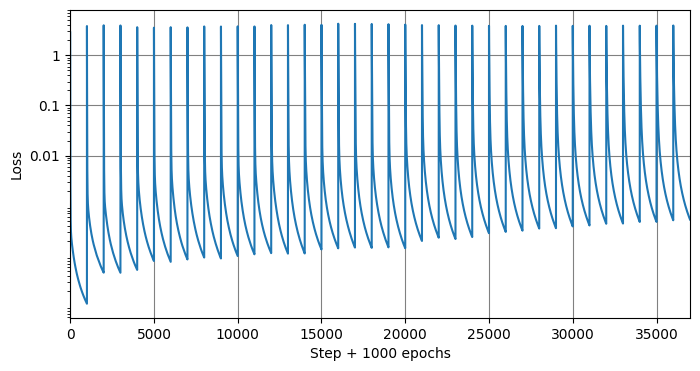

In [6]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.hstack( [ i for i in global_loss if len(i)>0 ] )

plt.figure(figsize=(8, 4))
# plt.ylim( (0, 10) )
plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, len(new_global_loss)) )


def generate_custom_ticks(start, horizon, end, increment, label_increment):
    custom_ticks = list(range(start, end+1 , increment))
    custom_tick_labels = [ str(i) for i in range(start, horizon , label_increment)]
    return custom_ticks, custom_tick_labels

# Define the parameters
start_value = 0
end_value = len(new_global_loss) 
tick_increment = 1000
label_increment = 50
horizon = 1000

# custom_ticks, custom_tick_labels = generate_custom_ticks(start_value, horizon, end_value, tick_increment, label_increment)

# plt.xticks(custom_ticks, custom_tick_labels, rotation=45, fontsize=7)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss )
plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')

# plt.savefig('./figures/loss_evolution.png', dpi=380, bbox_inches='tight')


In [ ]:
context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()

V_it_inv = np.identity(20)

vals = []
rates = []

T = 10000

for t in range(1,T):

    norm_context, distribution = context_generator.get_context(True)
    dist_test.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 

    latent_X = alg.func( torch.from_numpy( norm_context ).float().to(alg.device) ).cpu().detach().numpy()

    V_it_inv = V_it_inv - ( V_it_inv @ latent_X.T @ latent_X @ V_it_inv ) / ( 1 + latent_X @ V_it_inv @ latent_X.T ) 

    val =  latent_X @ V_it_inv @ latent_X.T  
    rate = t**(2/3)  * ( 1.01 * np.log(t) )**(1/3)

    vals.append(val[0][0])
    rates.append(1/rate)

plt.plot(range(1,T), vals, '.' , markersize = 0.01, color = 'blue', label = 'pseudo-count')
plt.plot(range(1,T), rates, '.', markersize = 0.01, color = 'red', label = 'exploration threshold')
plt.yscale('log')
plt.legend()

NameError: name 'synthetic_data' is not defined